In [87]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import time

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

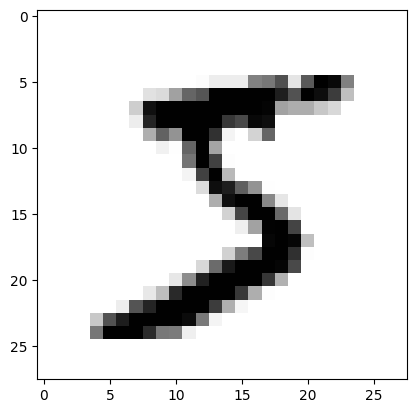

In [13]:
plt.imshow(x_train[0], cmap=plt.cm.binary)

In [28]:
image = x_train[0]
input_shape = np.shape(image)
output_shape = np.shape(image.flatten())
min_val = np.min(image)
max_val = np.max(image)

print(f'Input Shape: ' + str(input_shape))
print(f'Output Shape: ' + str(output_shape))
print(f'Min Value: ' + str(min_val))
print(f'Max Value: ' + str(max_val))

Input Shape: (28, 28)
Output Shape: (784,)
Min Value: 0.0
Max Value: 1.0


In [20]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [21]:
x_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

# Best Dense Model

### Stats
- Loss: 0.06887
- Acc: 98.31%

### Model
- Optimizer: Adam
- Loss: SparseCategoricalCrossentropy

1. Dense, 256 neurons, 20% dropout, relu
2. Dense, 256 neurons, 20% dropout, relu
3. Dense, 10 neurons

In [ ]:
concept = 'best'
neurons = [256]
layers = [2]
dropout = [0.2]

for num_neurons in neurons:
    for num_layers in layers:
        for num_dropout in dropout:

            # Sequential model
            model = tf.keras.models.Sequential()

            # Start by flattening inputs
            model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
            
            # Add dense layers
            for l in range(num_layers):
                model.add(tf.keras.layers.Dense(num_neurons, activation='relu'))
                model.add(tf.keras.layers.Dropout(num_dropout))

            # Always add a final dense layer with 10 neurons for classification
            model.add(tf.keras.layers.Dense(10))

            # Tensorboard
            log_fullfile = f'./tensorboard_logs/concept:{concept}-neurons:{num_neurons}-layers:{num_layers}-dropout:{num_dropout}-{time.time()}'
            tensorboard_callback = TensorBoard(log_dir=log_fullfile)

            # Compile model
            model.compile(
                optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
            )

            # Train
            model.fit(
                x_train,
                y_train,
                epochs=10,
                validation_data=(x_test, y_test),
                callbacks=[tensorboard_callback]
            )

# Best Conv Model

### Stats
- Loss: 0.02161
- Acc: 99.42%

### Model
- Optimizer: Adam
- Loss: SparseCategoricalCrossentropy
- Augmentations:
    - rotation_range: 10
    - zoom_range: 0.1
    - width_shift_range: 0.1
    - height_shift_range: 0.1

1. Conv2D:32:3x3:relu
2. Max:2x2
3. Dropout:0.2
4. Conv2D:64:3x3:relu
5. Max:2x2
6. Dropout:0.2
7. Flatten
8. Dense:64:relu
9. Dense:10

In [83]:
# Since we're using convolutional layers now, we need to do an extra step of preprocessing
# All we're doing here is adding a dimension at the lowest level to represent color channels
# because that's what convolutional layers expect.
# 
# Dimensions:
#   1. Number of images
#   2. Rows
#   3. Columns
#   4. Pixel channels to represent color
conv_x_train = x_train.reshape(len(x_train), 28, 28, 1)
conv_x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [96]:
concept = 'conv_with_aug'

# Tensorboard
log_fullfile = f'./tensorboard_logs/concept:{concept}'
log_fullfile += '-Conv:32:3x3'
log_fullfile += '-Max:2x2'
log_fullfile += '-Dropout:0.25'
log_fullfile += '-Conv:64:3x3'
log_fullfile += '-Max:2x2'
log_fullfile += '-Dropout:0.25'
log_fullfile += '-Flatten'
log_fullfile += '-Dense:64'
log_fullfile += '-Dense:10'
log_fullfile += f'-{time.time()}'
tensorboard_callback = TensorBoard(log_dir=log_fullfile)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.12,
    width_shift_range=0.12,
    height_shift_range=0.12
)

datagen.fit(conv_x_train)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    datagen.flow(
        conv_x_train,
        y_train,
        batch_size=32  
    ),
    epochs=10,
    validation_data=(conv_x_test, y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.4055 - accuracy: 0.8711 - val_loss: 0.0587 - val_accuracy: 0.9807
Epoch 2/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1764 - accuracy: 0.9466 - val_loss: 0.0445 - val_accuracy: 0.9865
Epoch 3/10
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1401 - accuracy: 0.9565 - val_loss: 0.0392 - val_accuracy: 0.9869
Epoch 4/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1206 - accuracy: 0.9637 - val_loss: 0.0287 - val_accuracy: 0.9906
Epoch 5/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1139 - accuracy: 0.9653 - val_loss: 0.0310 - val_accuracy: 0.9901
Epoch 6/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1060 - accuracy: 0.9673 - val_loss: 0.0250 - val_accuracy: 0.9914
Epoch 7/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0928 - accuracy: 0.9707 - val_loss: 0.0250 -